# Stateful vs Stateless Computations in JAX


### Summary : JAX is functional and stateless

https://jax.readthedocs.io/en/latest/jax-101/07-state.html

## In machine learning, program state most often comes in the form of:

<ul>
<li>model parameters,</li>
<li>optimizer state, and </li>
<li>stateful layers, such as BatchNorm.</li>
</ul>


In [8]:
import jax
import jax.numpy as jnp

class Counter:
    """A simple counter."""

    def __init__(self):
        self.n = 0

    def count(self) -> int:
        """Increments the counter and returns the new value."""
        self.n += 1
        return self.n

    def reset(self):
        """Resets the counter to zero."""
        self.n = 0


counter = Counter()

for _ in range(3):
    print(counter.count())

1
2
3


In [9]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
    print(fast_count())

1
1
1


`count` is only called once, when JAX compiles the method call. Moreover, since the return value doesn’t depend on the arguments to `count`, once it returns the first 1, subsequent calls to fast_count will always return 1. This won’t do. So, how do we fix it?

## The solution: explicit state

In [6]:
from typing import Tuple

CounterState = int

class CounterV2:

    def count(self, n: CounterState) -> Tuple[int, CounterState]:
    # You could just return n+1, but here we separate its role as 
    # the output and as the counter state for didactic purposes.
        return n+1, n+1

    def reset(self) -> CounterState:
        return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
    value, state = counter.count(state)
    print(value)

1
2
3


In this new version of Counter, we moved n to be an argument of count, and added another return value that represents the new, updated, state. To use this counter, we now need to keep track of the state explicitly. But in return, we can now safely jax.jit this counter:

## A General Strategy

class StatefulClass

    state: State

    def stateful_method(*args, **kwargs) -> Output:

class StatelessClass

    def stateless_method(state: State, *args, **kwargs) -> (Output, State):


This is a common functional programming pattern, and, essentially, is the way that state is handled in all JAX programs.

## Linear Regression 

In [20]:
from typing import NamedTuple

class Params(NamedTuple):
    weight: jnp.ndarray
    bias: jnp.ndarray


def init(rng) -> Params:
    """Returns the initial model params."""
    weights_key, bias_key = jax.random.split(rng)
    weight = jax.random.normal(weights_key, ())
    bias = jax.random.normal(bias_key, ())
    return Params(weight, bias)


def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
    """Computes the least squares error of the model's predictions on x against y."""
    pred = params.weight * x + params.bias
    return jnp.mean((pred - y) ** 2)


LEARNING_RATE = 0.005

@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
    """Performs one SGD update step on params using the given data."""
    grad = jax.grad(loss)(params, x, y)

    # If we were using Adam or another stateful optimizer,
    # we would also do something like
    # ```
    # updates, new_optimizer_state = optimizer(grad, optimizer_state)
    # ```
    # and then use `updates` instead of `grad` to actually update the params.
    # (And we'd include `new_optimizer_state` in the output, naturally.)

    new_params = jax.tree_multimap(
        lambda param, g: param - g * LEARNING_RATE, params, grad)

    return new_params

Notice that we manually pipe the params in and out of the update function.

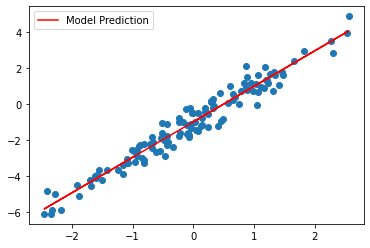

In [23]:
import matplotlib.pyplot as plt

rng = jax.random.PRNGKey(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
    params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();

The strategy described above is how any (jitted) JAX program must handle state.

Handling parameters manually seems fine if you’re dealing with two parameters, but what if it’s a neural net with dozens of layers? You might already be getting worried about two things:

Are we supposed to initialize them all manually, essentially repeating what we already write in the forward pass definition?
Are we supposed to pipe all these things around manually?

The details can be tricky to handle, but there are examples of libraries that take care of this for you. See JAX Neural Network Libraries for some examples.

https://github.com/google/jax#neural-network-libraries

src: https://jax.readthedocs.io/en/latest/jax-101/07-state.html